In [1]:

from torch.nn.utils.rnn import pad_sequence
import pickle
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from utilities3 import *
from Adam import Adam


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)


torch.backends.cudnn.deterministic = True
set_seed(0)

################################################################
# fourier layer
################################################################


class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, s1=32, s2=32):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes1 = modes1
        self.modes2 = modes2
        self.s1 = s1
        self.s2 = s2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, u, x_in=None, x_out=None, iphi=None, code=None):
        batchsize = u.shape[0]

        # Compute Fourier coeffcients up to factor of e^(- something constant)
        if x_in == None:
            u_ft = torch.fft.rfft2(u)
            s1 = u.size(-2)
            s2 = u.size(-1)
        else:
            u_ft = self.fft2d(u, x_in, iphi, code)
            s1 = self.s1
            s2 = self.s2

        # Multiply relevant Fourier modes
        # print(u.shape, u_ft.shape)
        factor1 = self.compl_mul2d(
            u_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        factor2 = self.compl_mul2d(
            u_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        if x_out == None:
            out_ft = torch.zeros(batchsize, self.out_channels, s1,
                                 s2 // 2 + 1, dtype=torch.cfloat, device=u.device)
            out_ft[:, :, :self.modes1, :self.modes2] = factor1
            out_ft[:, :, -self.modes1:, :self.modes2] = factor2
            u = torch.fft.irfft2(out_ft, s=(s1, s2))
        else:
            out_ft = torch.cat([factor1, factor2], dim=-2)
            u = self.ifft2d(out_ft, x_out, iphi, code)

        return u

    def fft2d(self, u, x_in, iphi=None, code=None):
        # u (batch, channels, n)
        # x_in (batch, n, 2) locations in [0,1]*[0,1]
        # iphi: function: x_in -> x_c

        batchsize = x_in.shape[0]
        N = x_in.shape[1]
        device = x_in.device
        m1 = 2 * self.modes1
        m2 = 2 * self.modes2 - 1

        # wavenumber (m1, m2)
        k_x1 = torch.cat((torch.arange(start=0, end=self.modes1, step=1),
                          torch.arange(start=-(self.modes1), end=0, step=1)), 0).reshape(m1, 1).repeat(1, m2).to(device)
        k_x2 = torch.cat((torch.arange(start=0, end=self.modes2, step=1),
                          torch.arange(start=-(self.modes2-1), end=0, step=1)), 0).reshape(1, m2).repeat(m1, 1).to(device)

        # print(x_in.shape)
        if iphi == None:
            x = x_in
        else:
            x = iphi(x_in, code)

        # print(x.shape)
        # K = <y, k_x>,  (batch, N, m1, m2)
        K1 = torch.outer(x[..., 0].view(-1), k_x1.view(-1)
                         ).reshape(batchsize, N, m1, m2)
        K2 = torch.outer(x[..., 1].view(-1), k_x2.view(-1)
                         ).reshape(batchsize, N, m1, m2)
        K = K1 + K2

        # basis (batch, N, m1, m2)
        basis = torch.exp(-1j * 2 * np.pi * K).to(device)

        # Y (batch, channels, N)
        u = u + 0j
        Y = torch.einsum("bcn,bnxy->bcxy", u, basis)
        return Y

    def ifft2d(self, u_ft, x_out, iphi=None, code=None):
        # u_ft (batch, channels, kmax, kmax)
        # x_out (batch, N, 2) locations in [0,1]*[0,1]
        # iphi: function: x_out -> x_c

        batchsize = x_out.shape[0]
        N = x_out.shape[1]
        device = x_out.device
        m1 = 2 * self.modes1
        m2 = 2 * self.modes2 - 1

        # wavenumber (m1, m2)
        k_x1 = torch.cat((torch.arange(start=0, end=self.modes1, step=1),
                          torch.arange(start=-(self.modes1), end=0, step=1)), 0).reshape(m1, 1).repeat(1, m2).to(device)
        k_x2 = torch.cat((torch.arange(start=0, end=self.modes2, step=1),
                          torch.arange(start=-(self.modes2-1), end=0, step=1)), 0).reshape(1, m2).repeat(m1, 1).to(device)

        if iphi == None:
            x = x_out
        else:
            x = iphi(x_out, code)

        # K = <y, k_x>,  (batch, N, m1, m2)
        K1 = torch.outer(x[:, :, 0].view(-1), k_x1.view(-1)
                         ).reshape(batchsize, N, m1, m2)
        K2 = torch.outer(x[:, :, 1].view(-1), k_x2.view(-1)
                         ).reshape(batchsize, N, m1, m2)
        K = K1 + K2

        # basis (batch, N, m1, m2)
        basis = torch.exp(1j * 2 * np.pi * K).to(device)

        # coeff (batch, channels, m1, m2)
        u_ft2 = u_ft[..., 1:].flip(-1, -2).conj()
        u_ft = torch.cat([u_ft, u_ft2], dim=-1)

        # Y (batch, channels, N)
        Y = torch.einsum("bcxy,bnxy->bcn", u_ft, basis)
        Y = Y.real
        return Y


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_channels, out_channels, is_mesh=True, s1=40, s2=40):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.is_mesh = is_mesh
        self.s1 = s1
        self.s2 = s2

        # input channel is 3: (a(x, y), x, y)
        self.fc0 = nn.Linear(in_channels, self.width)

        self.conv0 = SpectralConv2d(
            self.width, self.width, self.modes1, self.modes2, s1, s2)
        self.conv1 = SpectralConv2d(
            self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(
            self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(
            self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(
            self.width, self.width, self.modes1, self.modes2, s1, s2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.b0 = nn.Conv2d(2, self.width, 1)
        self.b1 = nn.Conv2d(2, self.width, 1)
        self.b2 = nn.Conv2d(2, self.width, 1)
        self.b3 = nn.Conv2d(2, self.width, 1)
        self.b4 = nn.Conv1d(2, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, u, code=None, x_in=None, x_out=None, iphi=None):
        # u (batch, Nx, d) the input value, the mesh points for this example
        # code (batch, Nx, d) the input features, the raduis for this example
        # x_in (batch, Nx, 2) the input mesh (sampling mesh)
        # xi (batch, xi1, xi2, 2) the computational mesh (uniform)
        # x_in (batch, Nx, 2) the input mesh (query mesh)

        if self.is_mesh and x_in == None:
            x_in = u
        if self.is_mesh and x_out == None:
            x_out = u
        grid = self.get_grid([u.shape[0], self.s1, self.s2],
                             u.device).permute(0, 3, 1, 2)

        u = self.fc0(u)
        u = u.permute(0, 2, 1)

        uc1 = self.conv0(u, x_in=x_in, iphi=iphi, code=code)
        uc3 = self.b0(grid)
        uc = uc1 + uc3
        uc = F.gelu(uc)

        uc1 = self.conv1(uc)
        uc2 = self.w1(uc)
        uc3 = self.b1(grid)
        uc = uc1 + uc2 + uc3
        uc = F.gelu(uc)

        uc1 = self.conv2(uc)
        uc2 = self.w2(uc)
        uc3 = self.b2(grid)
        uc = uc1 + uc2 + uc3
        uc = F.gelu(uc)

        uc1 = self.conv3(uc)
        uc2 = self.w3(uc)
        uc3 = self.b3(grid)
        uc = uc1 + uc2 + uc3
        uc = F.gelu(uc)

        u = self.conv4(uc, x_out=x_out, iphi=iphi, code=code)
        u3 = self.b4(x_out.permute(0, 2, 1))
        u = u + u3

        u = u.permute(0, 2, 1)
        u = self.fc1(u)
        u = F.gelu(u)
        u = self.fc2(u)
        return u

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat(
            [batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat(
            [batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


class IPHI(nn.Module):
    def __init__(self, width=32):
        super(IPHI, self).__init__()
        """
        inverse phi: x -> xi
        """
        self.width = width
        self.fc0 = nn.Linear(4, self.width)
        self.fc_code = nn.Linear(145, self.width)
        self.fc_no_code = nn.Linear(3*self.width, 4*self.width)
        self.fc1 = nn.Linear(4*self.width, 4*self.width)
        self.fc2 = nn.Linear(4*self.width, 4*self.width)
        self.fc3 = nn.Linear(4*self.width, 2)
        self.center = torch.tensor([0.5, 0.5], device="cuda").reshape(1, 1, 2)

        self.B = np.pi*torch.pow(2, torch.arange(0, self.width//4,
                                 dtype=torch.float, device="cuda")).reshape(1, 1, 1, self.width//4)

    def forward(self, x, code=None):
        # x (batch, N_grid, 2)
        # code (batch, N_features)

        # some feature engineering
        angle = torch.atan2(x[:, :, 1] - self.center[:, :, 1],
                            x[:, :, 0] - self.center[:, :, 0])
        radius = torch.norm(x - self.center, dim=-1, p=2)
        xd = torch.stack([x[:, :, 0], x[:, :, 1], angle, radius], dim=-1)

        # sin features from NeRF
        b, n, d = xd.shape[0], xd.shape[1], xd.shape[2]
        x_sin = torch.sin(self.B * xd.view(b, n, d, 1)
                          ).view(b, n, d*self.width//4)
        x_cos = torch.cos(self.B * xd.view(b, n, d, 1)
                          ).view(b, n, d*self.width//4)
        xd = self.fc0(xd)
        xd = torch.cat([xd, x_sin, x_cos], dim=-1).reshape(b, n, 3*self.width)

        if code != None:
            cd = self.fc_code(code)
            cd = cd.unsqueeze(1).repeat(1, xd.shape[1], 1)
            xd = torch.cat([cd, xd], dim=-1)
        else:
            xd = self.fc_no_code(xd)

        xd = self.fc1(xd)
        xd = F.gelu(xd)
        xd = self.fc2(xd)
        xd = F.gelu(xd)
        xd = self.fc3(xd)
        return x + x * xd


################################################################
# configs
################################################################

# batch_size = 20
learning_rate_fno = 0.001
learning_rate_iphi = 0.0001

epochs = 201

modes = 12
width = 32


In [2]:
data_file = '../data/poisson/poisson_geo_struc_msh.pkl'
with open(data_file, "rb") as f:
    data = pickle.load(f)
PADDING_VALUE = -2
input_rr = data["radius"]
input_rr = torch.tensor(np.array(input_rr))  # (B,Nr)
nodes_all = data['nodes']
input_xy=torch.tensor(np.array(nodes_all)[:,:,:2])  # (B,N,2)
solutions_all = data['solutions']
input_s=torch.tensor(np.array(solutions_all))[:, :, None]  # (B,N,1)

torch.Size([4800, 145]) torch.Size([4800, 2737, 1]) torch.Size([4800, 2737, 2])
1482657 50530
0 7.123323940031696 1.5670155370235443 0.405206329320293
1 4.656655850005336 0.3260153655211131 0.22889110746232794
2 4.591109002998564 0.1847367904583613 0.1337599583609118
3 4.406781393976416 0.12451204041639964 0.114582309516443
4 4.356537989981007 0.10278068641821543 0.1027746430840917
5 4.58361197198974 0.09406207432349523 0.0985582385035379
6 4.432261453999672 0.08213641971349717 0.06579764538462414
7 4.525073441036511 0.07495742196838061 0.06137368601625111
8 4.773401815036777 0.07097743466496467 0.07863553338602719
9 4.355361750989687 0.06533190101385117 0.06388347571735875
10 4.464772787003312 0.05980548794070879 0.11255681008522357
11 4.581264958018437 0.06481693754593532 0.06592146740864953
12 4.354424847988412 0.05453180541594823 0.05384111205902227
13 4.362240677990485 0.05243416552742322 0.045445016182828805
14 4.356068623019382 0.05106242209672928 0.04426368884897351
15 5.009475

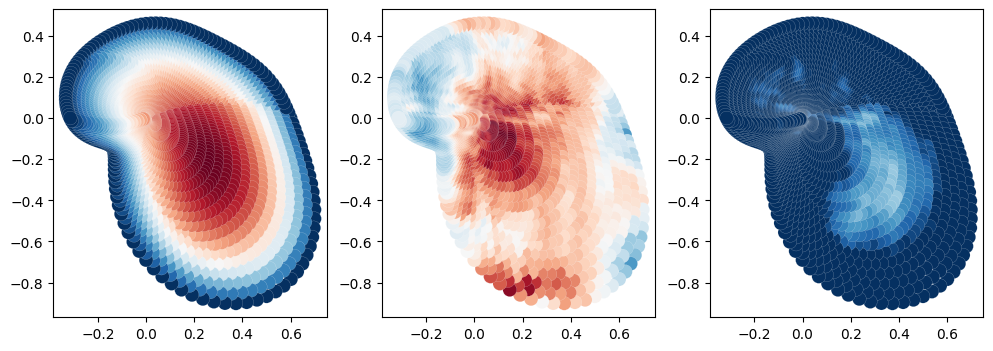

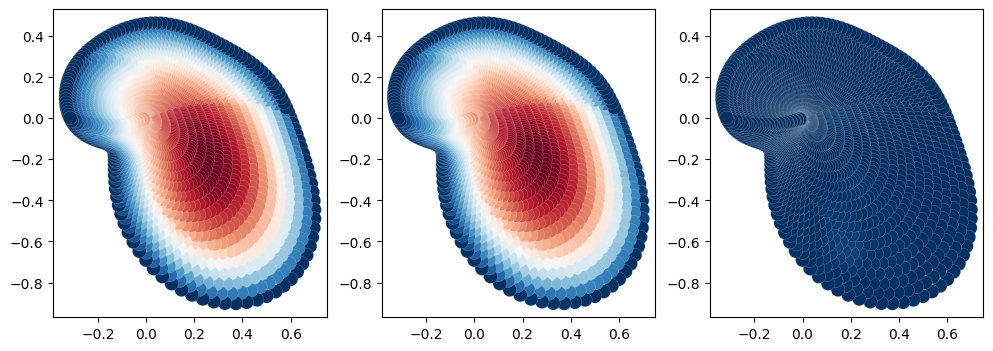

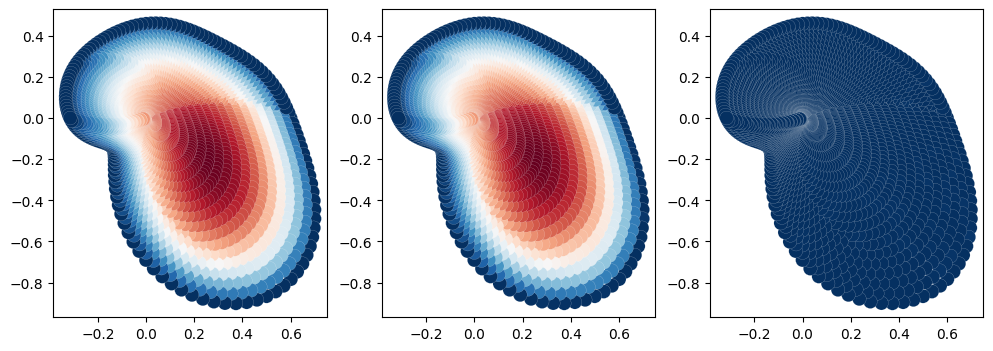

In [3]:
train_rr, test_rr, train_s, test_s, train_xy, test_xy = train_test_split(
    input_rr, input_s, input_xy, test_size=0.2, random_state=42)
ntest = test_rr.shape[0]
ntrain = train_rr.shape[0]
print(train_rr.shape, train_s.shape, train_xy.shape)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    train_rr, train_s, train_xy), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    test_rr, test_s, test_xy), batch_size=512, shuffle=False)

################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width, in_channels=2, out_channels=1).cuda()
model_iphi = IPHI().cuda()
print(count_params(model), count_params(model_iphi))

optimizer_fno = Adam(model.parameters(),
                     lr=learning_rate_fno, weight_decay=1e-4)
scheduler_fno = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_fno, T_max=200)
optimizer_iphi = Adam(model_iphi.parameters(),
                      lr=learning_rate_iphi, weight_decay=1e-4)
scheduler_iphi = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_iphi, T_max=200)

myloss = LpLoss(size_average=False)
training_loss = []
testing_loss = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_reg = 0
    for rr, sigma, mesh in train_loader:
        rr, sigma, mesh = rr.cuda(), sigma.cuda(), mesh.cuda()
        batch_size = sigma.shape[0]
        mask = sigma != PADDING_VALUE
        mask = mask.float()
        optimizer_fno.zero_grad()
        optimizer_iphi.zero_grad()
        out = model(mesh, code=rr, iphi=model_iphi)
        sigma = sigma*mask
        out = out*mask
        loss = myloss(out.view(batch_size, -1), sigma.view(batch_size, -1))
        loss.backward()

        optimizer_fno.step()
        optimizer_iphi.step()
        train_l2 += loss.item()

    scheduler_fno.step()
    scheduler_iphi.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for rr, sigma, mesh in test_loader:
            rr, sigma, mesh = rr.cuda(), sigma.cuda(), mesh.cuda()
            batch_size = sigma.shape[0]
            mask = sigma != PADDING_VALUE
            mask = mask.float()
            out = model(mesh, code=rr, iphi=model_iphi)
            sigma = sigma*mask.float()
            out = out*mask.float()
            test_l2 += myloss(out.view(batch_size, -1),
                              sigma.view(batch_size, -1)).item()

    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)
    training_loss.append(train_l2)
    testing_loss.append(test_l2)
    if ep % 100 == 0:
        # torch.save(model, '../model/elas_v2_'+str(ep))
        # torch.save(model_iphi, '../model/elas_v2_iphi_'+str(ep))
        XY = mesh[-1].squeeze().detach().cpu().numpy()
        truth = sigma[-1].squeeze().detach().cpu().numpy()
        pred = out[-1].squeeze().detach().cpu().numpy()

        lims = dict(cmap='RdBu_r', vmin=truth.min(), vmax=truth.max())
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        ax[0].scatter(XY[:, 0], XY[:, 1], 100, truth,
                      edgecolor='w', lw=0.1, **lims)
        ax[1].scatter(XY[:, 0], XY[:, 1], 100, pred,
                      edgecolor='w', lw=0.1, **lims)
        ax[2].scatter(XY[:, 0], XY[:, 1], 100, truth -
                      pred, edgecolor='w', lw=0.1, **lims)
        fig.show()
        # plt.savefig('output.png')

Text(0, 0.5, 'L2 loss')

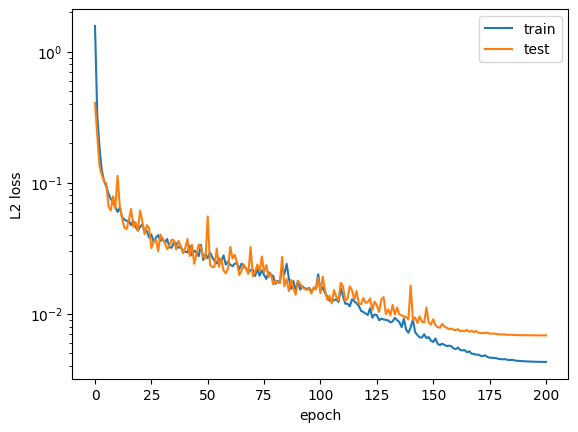

In [4]:
plt.plot(training_loss, label='train')
plt.plot(testing_loss, label='test')
plt.legend()
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('L2 loss')
